# Analysis testbram data with the ML model

In [1]:
import sys
sys.path.insert(0, '..')

from array import array
from lib.utility import *
import subprocess

import ROOT
from ROOT import TCanvas, TFile, TH1F, vector

Welcome to JupyROOT 6.24/06


## Some functions

In [2]:
def plot_waveform(wf, sign=1, xrange=None, time=None, time_cls=None, truth_time=None, truth_tag=None, filename=None, figsize=(12, 6), ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    # ax.set_xlabel('Time (index)', fontsize=16)
    # ax.set_ylabel('Amplitude (a.u.)', fontsize=16)

    wf_x = list(range(len(wf)))
    if sign < 0:
        wf = [-w for w in wf]
    ax.step(wf_x, wf,label='Waveform')
    if xrange is not None: ax.set_xlim(xrange)

    if time is not None:
        amp = [wf[int(t)] for t in time] 
        ax.plot(time, amp, 'o', label='Detected electrons')

    if time_cls is not None:
        amp = [wf[int(t)] for t in time_cls] 
        ax.plot(time_cls, amp, '^b', label='Detected clusters')

    if truth_time is not None:
        truth_time_pri = [t for i, t in enumerate(truth_time) if truth_tag[i] == 1]
        truth_amp_pri = [wf[int(t)] for i, t in enumerate(truth_time) if truth_tag[i] == 1]
        ax.vlines(truth_time_pri, 0, truth_amp_pri, color='orange', label='Primary electrons')

        truth_time_sec = [t for i, t in enumerate(truth_time) if truth_tag[i] == 2]
        truth_amp_sec = [wf[int(t)] for i, t in enumerate(truth_time) if truth_tag[i] == 2]
        ax.vlines(truth_time_sec, 0, truth_amp_sec, color='green', label='Secondary electrons')

    if filename is not None:
        plt.savefig(filename)

    ax.legend(fontsize=16)

def select_file(filename_prefix):
    root_command = 'root -q -l ../dataset/select.C"(\\"../dataset/' + filename_prefix + '.root\\", \\"../dataset/' + filename_prefix + '_sig.root\\")"'
    print(root_command)
    subprocess.run(root_command, shell=True)

def count_file(filename_prefix, nevt):
    python_command = 'python3 ../predict.py --input_file=../dataset/' + filename_prefix + '.root ' + \
                     '--output_file=../dataset/' + filename_prefix + '_pred.root ' + \
                     '--event_range=\'(0, ' + str(nevt) + ')\' ' + \
                     '--model_file=../results/testbeam_jdot_2GHz.pth ' + \
                     '--prob_cut=0.96 --with_tag=0 --clustering_cut=-1'
    print(python_command)
    subprocess.run(python_command, shell=True)

def show_waveform(filename, n=2, sign=-1, c=None, t=None, ax=None):
#     f = TFile('../results/testbeam_pred.root')
    f = TFile(filename)
    t = f.Get('signal')

    ncount = array('i', [-1])
    xcount = vector['double'](0)
    wf = vector['double'](0)
    t.SetBranchAddress('ncount', ncount)
    t.SetBranchAddress('xcount', xcount)
    t.SetBranchAddress('wf_i', wf)

#     n = t.GetEntries()
#     for i in range(n):
    t.GetEntry(n)

    if sign < 0:
        for i, w in enumerate(wf):
            wf[i] *= -1
    plot_waveform(wf, time=xcount, ax=ax)


## Dataset summary

| Run No. | Gas mixture | Sampling rate (GHz) | angle (deg) |
| ---- | ---- | ---- | ---- |
| 16, 17, 18 | 90/10 | 1.5 | 45 |
| 12, 13     | 90/10 | 1.5 | 0  |
| 10         | 90/10 | 2.0 | 45 |
| 11         | 90/10 | 2.0 | 0  |
| 47         | 90/10 | 2.0 | 60 |
| 49         | 90/10 | 2.0 | 30 |

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


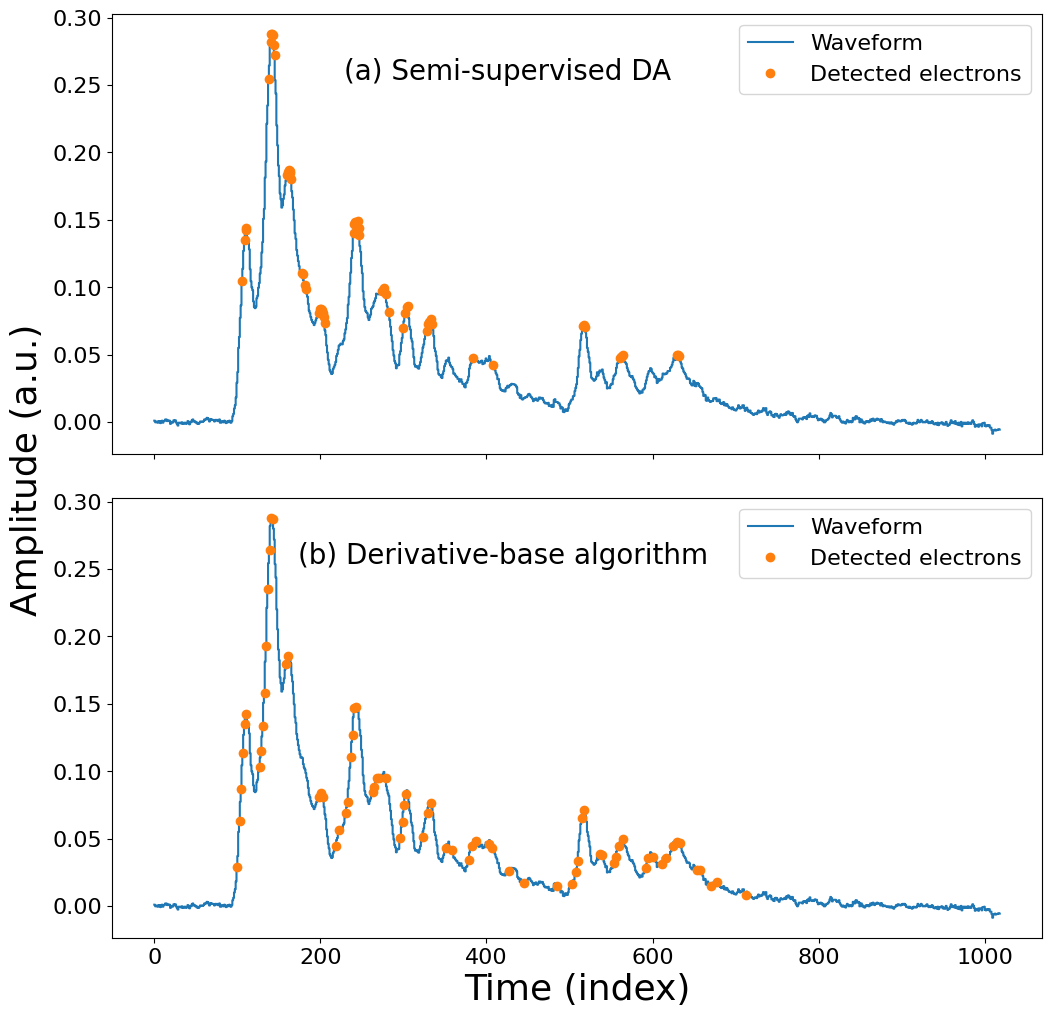

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)
show_waveform('../dataset/11_ch5_sig_pred.root', 2, ax=ax[0])
show_waveform('../dataset/11_ch5_sig_pred_d2.root', 2, ax=ax[1])
ax[0].text(0.25, 0.85, '(a) Semi-supervised DA', transform=ax[0].transAxes, fontsize=20)
ax[0].tick_params(labelsize=16)
ax[1].text(0.2, 0.85, '(b) Derivative-base algorithm', transform=ax[1].transAxes, fontsize=20)
ax[1].set_xlabel('Time (index)', fontsize=26)
ax[1].tick_params(labelsize=16)
fig.text(0.04, 0.5, 'Amplitude (a.u.)', va='center', rotation='vertical', fontsize=26)
plt.savefig('peak_finding.eps')

In [68]:
hist_data = []
func_data = []
fit_results = []

def read_data(h, fn, xmin, xmax, nx):
    hist = []
    hist.append(h.GetNbinsX())
    hist.append(h.GetXaxis().GetXmin())
    hist.append(h.GetXaxis().GetXmax())
    for i in range(h.GetNbinsX()):
        hist.append(h.GetBinContent(i+1))
    hist_data.append(hist)

    func = []
    func.append(nx)
    func.append(xmin)
    func.append(xmax)
    for i in range(nx):
        x = xmin + (xmax - xmin)/nx * i
        func.append(fn.Eval(x))
    func_data.append(func)

    mean = h.GetFunction('landau').GetParameter(1)
    err = h.GetFunction('landau').GetParError(1)
    fit_results.append((mean, err))

 FCN=23.4227 FROM MIGRAD    STATUS=CONVERGED     116 CALLS         117 TOTAL
                     EDM=1.39749e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.63839e+02   3.68035e+01   4.30851e-02   7.08594e-07
   2  MPV          1.50588e+01   2.45143e-01  -1.10484e-04   1.87386e-04
   3  Sigma        2.81286e+00   1.31238e-01  -1.15212e-05   8.34207e-03


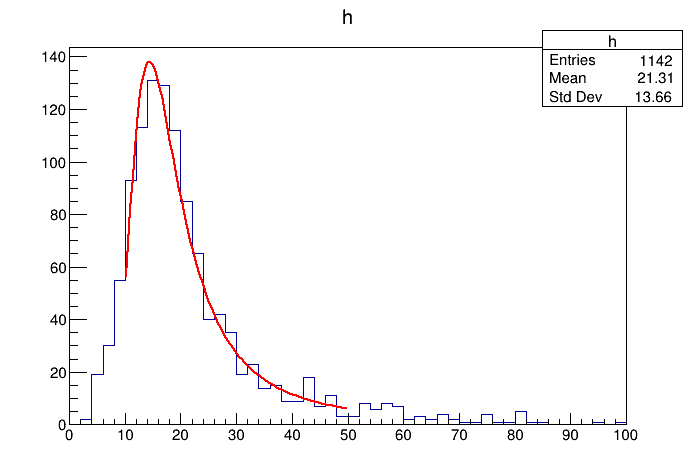

In [69]:
f = TFile('../dataset/11_ch5_sig_pred.root')
t = f.Get('signal')
c = TCanvas()
h = TH1F('h', 'h', 50, 0, 100)
t.Draw('ncount>>h')
h.Fit('landau', '', '', 10, 50)
c.Draw()

read_data(h, h.GetFunction('landau'), 10, 50, 100)

 FCN=43.7072 FROM MIGRAD    STATUS=CONVERGED     120 CALLS         121 TOTAL
                     EDM=1.0375e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.45620e+02   1.48508e+01  -2.95703e-02   8.42324e-06
   2  MPV          1.86707e+01   8.02014e-01  -6.10726e-04  -1.09971e-04
   3  Sigma        6.00765e+00   3.80846e-01   1.54889e-05   1.71872e-02


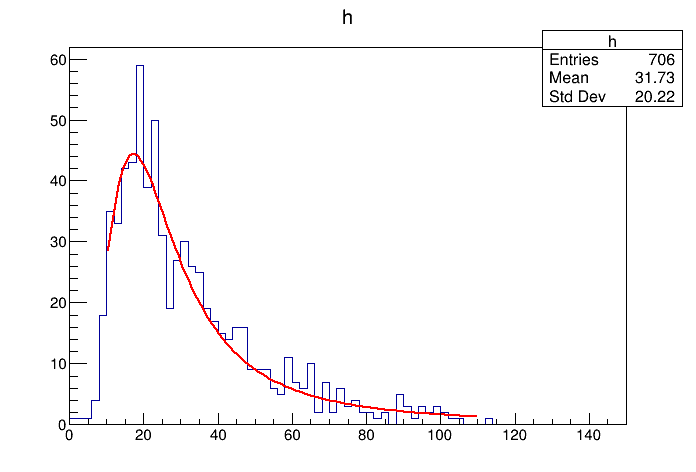

In [70]:
f = TFile('../dataset/49_ch5_sig_pred.root')
t = f.Get('signal')
c = TCanvas()
h = TH1F('h', 'h', 75, 0, 150)
t.Draw('ncount>>h')
h.Fit('landau', '', '', 10, 110)
c.Draw()

read_data(h, h.GetFunction('landau'), 10, 110, 100)

 FCN=17.2234 FROM MIGRAD    STATUS=CONVERGED     115 CALLS         116 TOTAL
                     EDM=2.55696e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.49418e+02   2.85445e+01   4.02315e-02  -2.31043e-05
   2  MPV          2.02771e+01   4.10746e-01   8.36046e-04  -9.99195e-05
   3  Sigma        4.08916e+00   2.97841e-01   2.68979e-05  -5.46869e-02


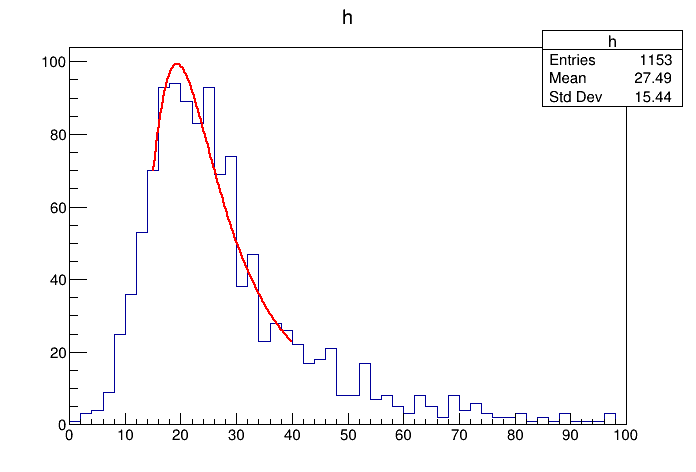

In [71]:
f = TFile('../dataset/10_ch5_sig_pred.root')
t = f.Get('signal')
c = TCanvas()
h = TH1F('h', 'h', 50, 0, 100)
t.Draw('ncount>>h')
h.Fit('landau', '', '', 15, 40)
c.Draw()

read_data(h, h.GetFunction('landau'), 15, 40, 100)

 FCN=35.0774 FROM MIGRAD    STATUS=CONVERGED     125 CALLS         126 TOTAL
                     EDM=1.35112e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.61972e+02   1.98380e+01   3.84725e-02  -3.14629e-05
   2  MPV          3.37371e+01   5.57949e-01   1.54711e-03  -2.02996e-03
   3  Sigma        6.35026e+00   2.96956e-01   1.78838e-05   6.99316e-02


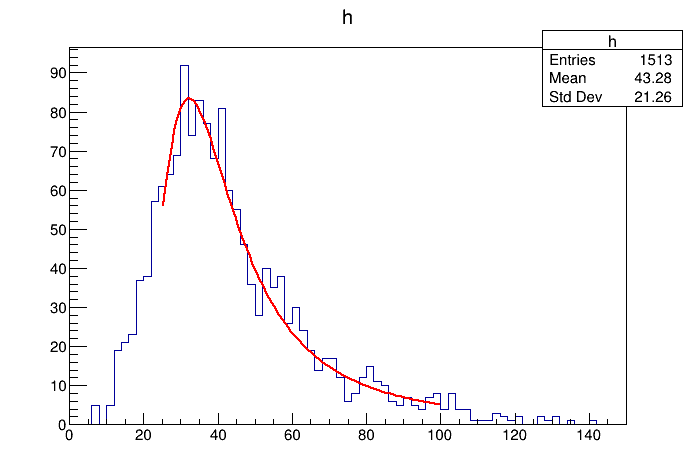

In [72]:
f = TFile('../dataset/47_ch5_sig_pred.root')
t = f.Get('signal')
c = TCanvas()
h = TH1F('h', 'h', 75, 0, 150)
t.Draw('ncount>>h')
h.Fit('landau', '', '', 25, 100)
c.Draw()

read_data(h, h.GetFunction('landau'), 25, 110, 100)

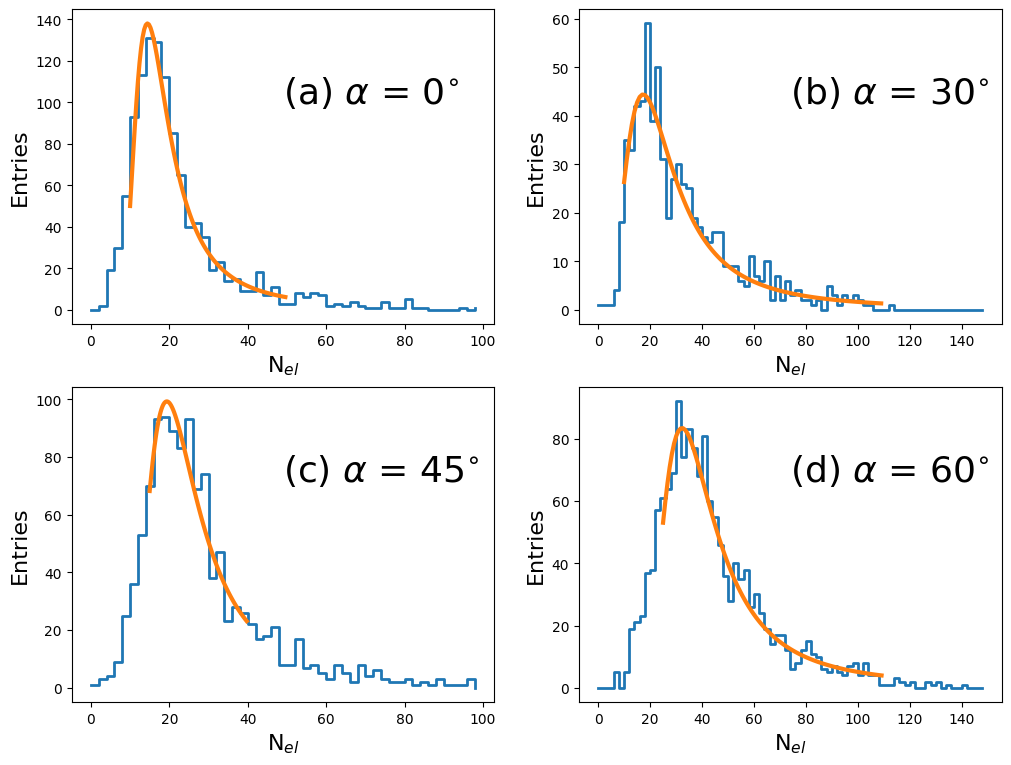

In [173]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

ax[0][0].step(np.arange(hist_data[0][1], hist_data[0][2], (hist_data[0][2]-hist_data[0][1])/hist_data[0][0]), hist_data[0][3:], where='post', lw=2)
ax[0][0].plot(np.arange(func_data[0][1], func_data[0][2], (func_data[0][2]-func_data[0][1])/func_data[0][0]), func_data[0][3:], lw=3)
ax[0][0].set_xlabel('N$_{el}$', fontsize=16)
ax[0][0].set_ylabel('Entries', fontsize=16)
ax[0][0].text(0.5, 0.7, r'(a) $\alpha$ = 0$^{\circ}$', transform=ax[0][0].transAxes, fontsize=26)

ax[0][1].step(np.arange(hist_data[1][1], hist_data[1][2], (hist_data[1][2]-hist_data[1][1])/hist_data[1][0]), hist_data[1][3:], where='post', lw=2)
ax[0][1].plot(np.arange(func_data[1][1], func_data[1][2], (func_data[1][2]-func_data[1][1])/func_data[1][0]), func_data[1][3:], lw=3)
ax[0][1].set_xlabel('N$_{el}$', fontsize=16)
ax[0][1].set_ylabel('Entries', fontsize=16)
ax[0][1].text(0.5, 0.7, r'(b) $\alpha$ = 30$^{\circ}$', transform=ax[0][1].transAxes, fontsize=26)

ax[1][0].step(np.arange(hist_data[2][1], hist_data[2][2], (hist_data[2][2]-hist_data[2][1])/hist_data[2][0]), hist_data[2][3:], where='post', lw=2)
ax[1][0].plot(np.arange(func_data[2][1], func_data[2][2], (func_data[2][2]-func_data[2][1])/func_data[2][0]), func_data[2][3:], lw=3)
ax[1][0].set_xlabel('N$_{el}$', fontsize=16)
ax[1][0].set_ylabel('Entries', fontsize=16)
ax[1][0].text(0.5, 0.7, r'(c) $\alpha$ = 45$^{\circ}$', transform=ax[1][0].transAxes, fontsize=26)

ax[1][1].step(np.arange(hist_data[3][1], hist_data[3][2], (hist_data[3][2]-hist_data[3][1])/hist_data[3][0]), hist_data[3][3:], where='post', lw=2)
ax[1][1].plot(np.arange(func_data[3][1], func_data[3][2], (func_data[3][2]-func_data[3][1])/func_data[3][0]), func_data[3][3:], lw=3)
ax[1][1].set_xlabel('N$_{el}$', fontsize=16)
ax[1][1].set_ylabel('Entries', fontsize=16)
ax[1][1].text(0.5, 0.7, r'(d) $\alpha$ = 60$^{\circ}$', transform=ax[1][1].transAxes, fontsize=26)

plt.savefig('nel.eps')


In [83]:
def expect_nel(alpha):
    delta = 12 # n/cm
    drift_len = 0.8 # cm
    return delta * drift_len * 1.3 * 1.6 / np.cos(alpha/180*np.pi)

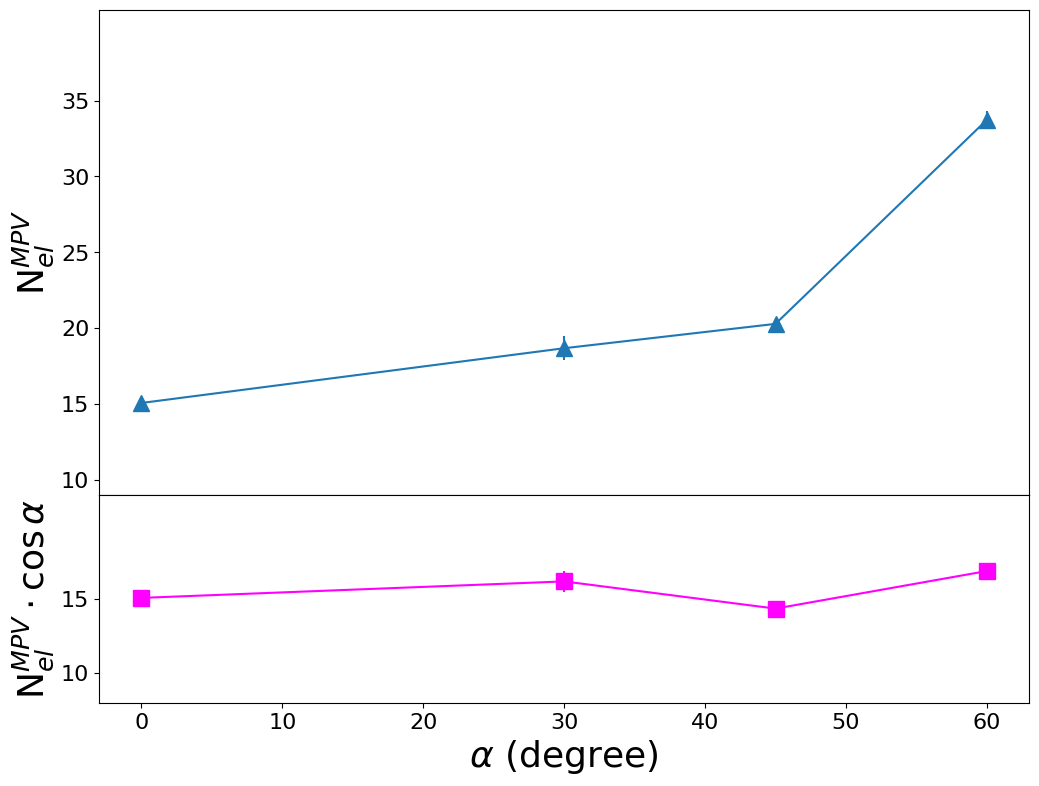

In [185]:
xdet = [0, 30, 45, 60]
ydet = []
ydet_err = []
yeff = []
yeff_err = []

for i, result in enumerate(fit_results):
    ydet.append(result[0])
    ydet_err.append(result[1])

    # yexp = expect_nel(xdet[i])
    # yeff.append(ydet[i]/yexp)
    # yeff_err.append(ydet[i]/yexp*ydet_err[i]/ydet[i])
    yeff.append(ydet[i]*np.cos(xdet[i]/180*np.pi))
    yeff_err.append(yeff[i]*result[1]/result[0])
xexp = np.arange(0, 60, 0.1)
yexp = [expect_nel(_x) for _x in xexp]

fig, ax = plt.subplots(2, 1, figsize=(12, 9), sharex=True, height_ratios=[0.7, 0.3])
fig.subplots_adjust(hspace=0)
ax[0].errorbar(xdet, ydet, yerr=ydet_err, marker='^', markersize=12)
# ax[0].plot(xexp, yexp)
ax[0].set_yticks(np.arange(10, 40, 5))
ax[0].set_ylim(9, 41)
ax[0].set_ylabel('N$_{el}^{MPV}$', fontsize=26)
ax[0].tick_params(labelsize=16)
ax[1].errorbar(xdet, yeff, yerr=yeff_err, marker='s', markersize=12, color='magenta')
ax[1].set_yticks(np.arange(10, 20, 5))
ax[1].set_ylim(8, 22)
ax[1].set_xlabel(r'$\alpha$ (degree)', fontsize=26)
ax[1].set_ylabel(r'N$_{el}^{MPV}\cdot\cos\alpha$', fontsize=26)
ax[1].tick_params(labelsize=16)

plt.savefig('nel_angle.eps')
